In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import pei.laborfunctions as lf
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.cm as cm
from dask.diagnostics import ProgressBar
plt.style.use('/home/aos/kyan/.config/matplotlib/esm2m.mplstyle')

# Plot Baselines

In [34]:
# Open baseline data
ds_base_esm2m = xr.open_dataarray('../data/processed/GFDL/esm2m_baseline_hottestmonths.nc')
ds_base_cesm2 = xr.open_dataarray('../data/processed/CESM2/cesm2_baseline_hottestmonths.nc')
ds_base_era = xr.open_dataarray('../data/processed/era_baseline_hottestmonths.nc')

Text(0.5, 0.98, '1980-2000 Baseline Capacity')

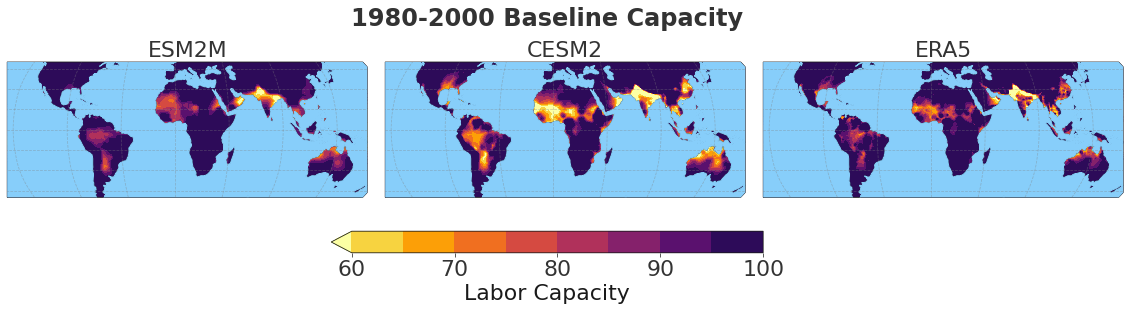

In [50]:
crs = ccrs.Robinson()

fig,ax=plt.subplots(ncols=3,figsize=(20,4),subplot_kw={'projection':crs})
levels = np.arange(60,105,5)

cmap = cm.get_cmap('inferno_r')
colors= cmap(np.arange(0,0.95,0.95/9))

im = lf.contour(ds_base_esm2m,'ESM2M',ax[0],levels=levels,cmap=None,colors=colors,over=None,crop=True,extend='min')
lf.grid(ax[0])
lf.contour(ds_base_cesm2,'CESM2',ax[1],levels=levels,cmap=None,colors=colors,over=None,crop=True,extend='min')
lf.grid(ax[1])
lf.contour(ds_base_era,'ERA5',ax[2],levels=levels,cmap=None,colors=colors,over=None,crop=True,extend='min')
lf.grid(ax[2])

# Single colorbar for all plots
fig.subplots_adjust(bottom=0.225)
cbar_ax = fig.add_axes([0.35, 0.125, 0.3, 0.075])
cbar = fig.colorbar(im, cax=cbar_ax,orientation='horizontal');
cbar.set_label('Labor Capacity',fontsize=22)
cbar.set_ticks(np.arange(60,110,10))
fig.subplots_adjust(wspace=.05,hspace=.05)
fig.suptitle('1980-2000 Baseline Capacity',fontweight='bold')

In [25]:
# Open baseline stdev data
base_sd_esm2m = xr.open_dataarray('../data/processed/GFDL/esm2m_base_sd_hottestmonths.nc').mean('ensemble')
base_sd_cesm2 = xr.open_dataarray('../data/processed/CESM2/cesm2_base_sd_hottestmonths.nc').mean('ensemble')
base_sd_era = xr.open_dataarray('../data/processed/era_base_sd_hottestmonths.nc')

Text(0.5, 0.98, '1980-2000 Baseline Standard Deviation')

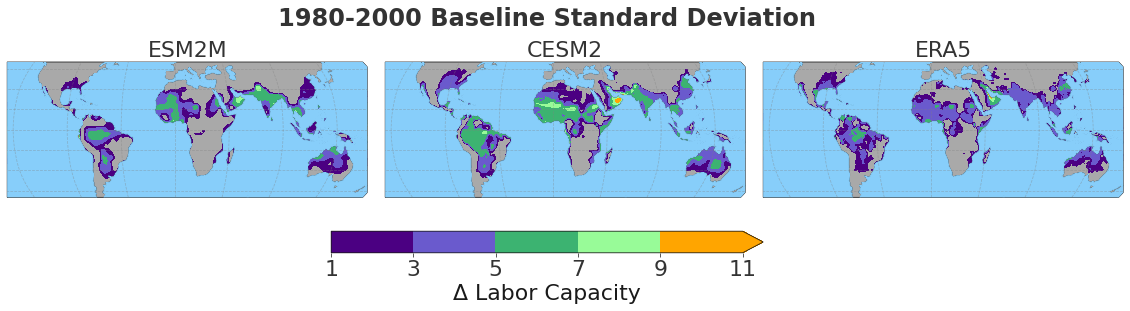

In [53]:
crs = ccrs.Robinson()

fig,ax=plt.subplots(ncols=3,figsize=(20,4),subplot_kw={'projection':crs})
levels = [1,3,5,7,9,11]
colors=['indigo','slateblue','mediumseagreen','palegreen','orange']

im = lf.contour(base_sd_esm2m,'ESM2M',ax[0],levels=levels,cmap=None,colors=colors,over=None,under='darkgray',crop=True)
lf.grid(ax[0])

levels = [0,1,3,5,7,9,11]
colors=['darkgray','indigo','slateblue','mediumseagreen','palegreen','orange']
lf.contour(base_sd_cesm2,'CESM2',ax[1],levels=levels,cmap=None,colors=colors,over=None,under='darkgray',crop=True)
lf.grid(ax[1])
lf.contour(base_sd_era,'ERA5',ax[2],levels=levels,cmap=None,colors=colors,over=None,under='darkgray',crop=True)
lf.grid(ax[2])

# Single colorbar for all plots
fig.subplots_adjust(bottom=0.225)
cbar_ax = fig.add_axes([0.35, 0.125, 0.3, 0.075])
cbar = fig.colorbar(im, cax=cbar_ax,orientation='horizontal',extendfrac=[0,0.05]);
cbar.set_label('Δ Labor Capacity',fontsize=22)
fig.subplots_adjust(wspace=.05,hspace=.05)
fig.suptitle('1980-2000 Baseline Standard Deviation',fontweight='bold')

# Calculate ESM2M Baseline + SD

In [14]:
# Load ESM2M labor capacity data
ds_esm2m = xr.open_mfdataset('../data/processed/GFDL/Monthly_Capacity/monthly_capacity_ens*_1950-2100.nc',combine='nested',concat_dim='ensemble',chunks={'time':1095})
ds_esm2m = ds_esm2m.rename({'__xarray_dataarray_variable__':'capacity'})

In [ ]:
# Calculate 1980-2000 baseline by month
with ProgressBar():
    ds_base_esm2m = lf.calc_baseline(ds_esm2m).compute()

In [15]:
# Slice 1980-2000 data
ds = ds_esm2m
ds_hist  = ds.sel(time=slice('1980-01-31','1999-12-31'))

# Calculate mean and stdev
ds_hist = xr.apply_ufunc(lf.max_avg,ds_hist['capacity'],input_core_dims=[['time']],output_core_dims=[['year']],exclude_dims=set(('time',)),vectorize=True,dask='allowed')
ds_hist_dev = ds_hist.std('year')

In [18]:
# Save baseline SD
ds_hist_dev.to_netcdf('../data/processed/GFDL/esm2m_base_sd_hottestmonths.nc')

# Calculate CESM2 Baseline + SD

In [19]:
# Load ESM2M labor capacity data
ds_cesm2 = xr.open_mfdataset('../data/processed/CESM2/Monthly_Capacity/*',combine='nested',concat_dim='ensemble',chunks={'time':1000}).rename({'__xarray_dataarray_variable__':'capacity'})

In [11]:
# Calculate 1980-2000 baseline by month
with ProgressBar():
    ds_base_cesm2 = lf.calc_baseline(ds_cesm2).compute()

[########################################] | 100% Completed |  3min 32.7s


In [13]:
ds_base_cesm2.to_netcdf('../data/processed/CESM2/cesm2_baseline_hottestmonths.nc')

In [20]:
# Slice 1980-2000 data
ds = ds_cesm2
ds_hist  = ds.sel(time=slice('1980-01-31','1999-12-31'))

# Calculate mean and stdev
ds_hist = xr.apply_ufunc(lf.max_avg,ds_hist['capacity'],input_core_dims=[['time']],output_core_dims=[['year']],exclude_dims=set(('time',)),vectorize=True,dask='allowed')
ds_hist_dev = ds_hist.std('year')

In [22]:
# Save baseline SD
ds_hist_dev.to_netcdf('../data/processed/CESM2/cesm2_base_sd_hottestmonths.nc')

# Calculate ERA Baseline + SD

In [3]:
# Open data
era_wbgt = xr.open_mfdataset('/local/ss23/ERA5/era5_daily_mean_WBGT*',concat_dim='time',combine='by_coords')
# Account for bounds of WBGT-capacity function
era_wbgt = era_wbgt.where(era_wbgt>25,25)
era_wbgt = era_wbgt.where(era_wbgt<33,33)

In [4]:
# Convert from WBGT to capacity
era_cap_daily = 100 - 25*((era_wbgt-25)**(2/3))

# Go from daily capacity to monthly capacity
era_cap_monthly = era_cap_daily.resample(time='1M').mean()
# Rename variables
era_cap_monthly = era_cap_monthly.rename({'WBGT':'capacity','longitude':'lon','latitude':'lat'})

In [5]:
# Calculate 1980-2000 baseline by month
with ProgressBar():
    # Slice 1980-2000 data
    ds = era_cap_monthly
    ds_hist  = ds.sel(time=slice('1980-01-31','1999-12-31'))

    # Calculate mean and stdev
    ds_hist = xr.apply_ufunc(lf.max_avg,ds_hist['capacity'],input_core_dims=[['time']],output_core_dims=[['year']],exclude_dims=set(('time',)),vectorize=True,dask='allowed')
    ds_hist_mean = ds_hist.mean('year')
    ds_hist_dev = ds_hist.std('year')

    # Return baseline as the lower bound of "envelope" around mean 
    ds_base = ds_hist_mean - 2*ds_hist_dev

[########################################] | 100% Completed |  3.6s


In [6]:
# Save baseline mean
ds_base.to_netcdf('../data/processed/era_baseline_hottestmonths.nc')

In [13]:
# Save baseline SD
ds_hist_dev.to_netcdf('../data/processed/era_base_sd_hottestmonths.nc')

# Summertime WBGT Calculation

In [11]:
# Open ERA data
era_wbgt = xr.open_mfdataset('/local/ss23/ERA5/era5_daily_mean_WBGT*',concat_dim='time',combine='by_coords')
era_wbgt = era_wbgt.resample(time='1M').mean()
era_wbgt = era_wbgt.sel(time=slice('1980-01-31','2019-12-31'))

In [12]:
era_wbgt_summer = xr.apply_ufunc(lf.wbgt_max_avg,era_wbgt['WBGT'],input_core_dims=[['time']],output_core_dims=[['year']],
                                 exclude_dims=set(('time',)),vectorize=True,dask='allowed',kwargs={'years':40})

In [13]:
era_wbgt_summer = era_wbgt_summer.assign_coords(year=range(1980,2020))

In [14]:
era_wbgt_summer = era_wbgt_summer.rename({'longitude':'lon','latitude':'lat'})

In [16]:
era_wbgt_summer.to_netcdf('../data/processed/era_wbgt_hottestmonths.nc')

# WBGT Time Series

In [124]:
# WBGT data
ds_esm2m = xr.open_dataarray('../data/processed/GFDL/esm2m_summer_wbgt_1980-2020.nc')
ds_cesm2 = xr.open_dataarray('../data/processed/CESM2/cesm2_summer_wbgt_1980-2020.nc')
ds_era = xr.open_dataarray('../data/processed/era_summer_wbgt_1980-2020.nc')

In [125]:
ds_era = ds_era.assign_coords({'lon':ds_era['lon']%360})
ds_era = ds_era.sortby('lon')

In [126]:
# area data
land_area_esm2m = xr.open_dataset('../data/processed/GFDL/esm2m.land_area')['land_area']
land_area_cesm2 = xr.open_dataset('../data/processed/CESM2/cesm2.land_area')['__xarray_dataarray_variable__'].isel(ensemble=0)
land_area_cesm2 = land_area_cesm2.fillna(0)

In [127]:
def plot_panel(wbgt_esm2m,wbgt_cesm2,wbgt_era,area_esm2m,area_cesm2,title,ax,ylabel=False,xlabel=False):
    '''Plot a single time series of WBGT 1980-2020'''
    
    esm2m = wbgt_esm2m.weighted(area_esm2m).mean(['lat','lon'])
    cesm2 = wbgt_cesm2.weighted(area_cesm2).mean(['lat','lon'])
    era = wbgt_era.weighted(area_cesm2).mean(['lat','lon'])
    
    # ESM2M WBGT
    # Plot ensemble envelope (x,y_min,y_max)
    ax.fill_between(esm2m['year'],esm2m.min(dim='ensemble'),esm2m.max(dim='ensemble'),alpha=0.15,color='mediumblue')
    esm2m.mean(dim='ensemble').plot(ax=ax,color='mediumblue',linewidth=3)

    # CESM2 WBGT
    ax.fill_between(cesm2['year'],cesm2.min(dim='ensemble'),cesm2.max(dim='ensemble'),alpha=0.15,color='tab:red')
    cesm2.mean(dim='ensemble').plot(ax=ax,color='tab:red',linewidth=3)

    # ERA WBGT
    era.plot(ax=ax,color='black',linewidth=3)
    
    # Set labels, limits, title
    if xlabel:
        ax.set_xlabel('Year',fontsize=22,fontweight='bold')
    else:
        ax.set_xlabel(None)
    if ylabel:
        ax.set_ylabel('WBGT ($^\circ$C)',fontsize=22,fontweight='bold')
    else:
        ax.set_ylabel(None)
    if region == 'Global':
        ax.set_ylim([11,17])
        ax.set_yticks(np.linspace(12,16,3))
    else:
        ax.set_ylim([15,28])
        ax.set_yticks(np.linspace(16,28,4))
    ax.set_xlim([1978,2022])
    ax.set_xticks(np.linspace(1980,2020,5))
    ax.set_title(title,fontsize=26,fontweight='bold')

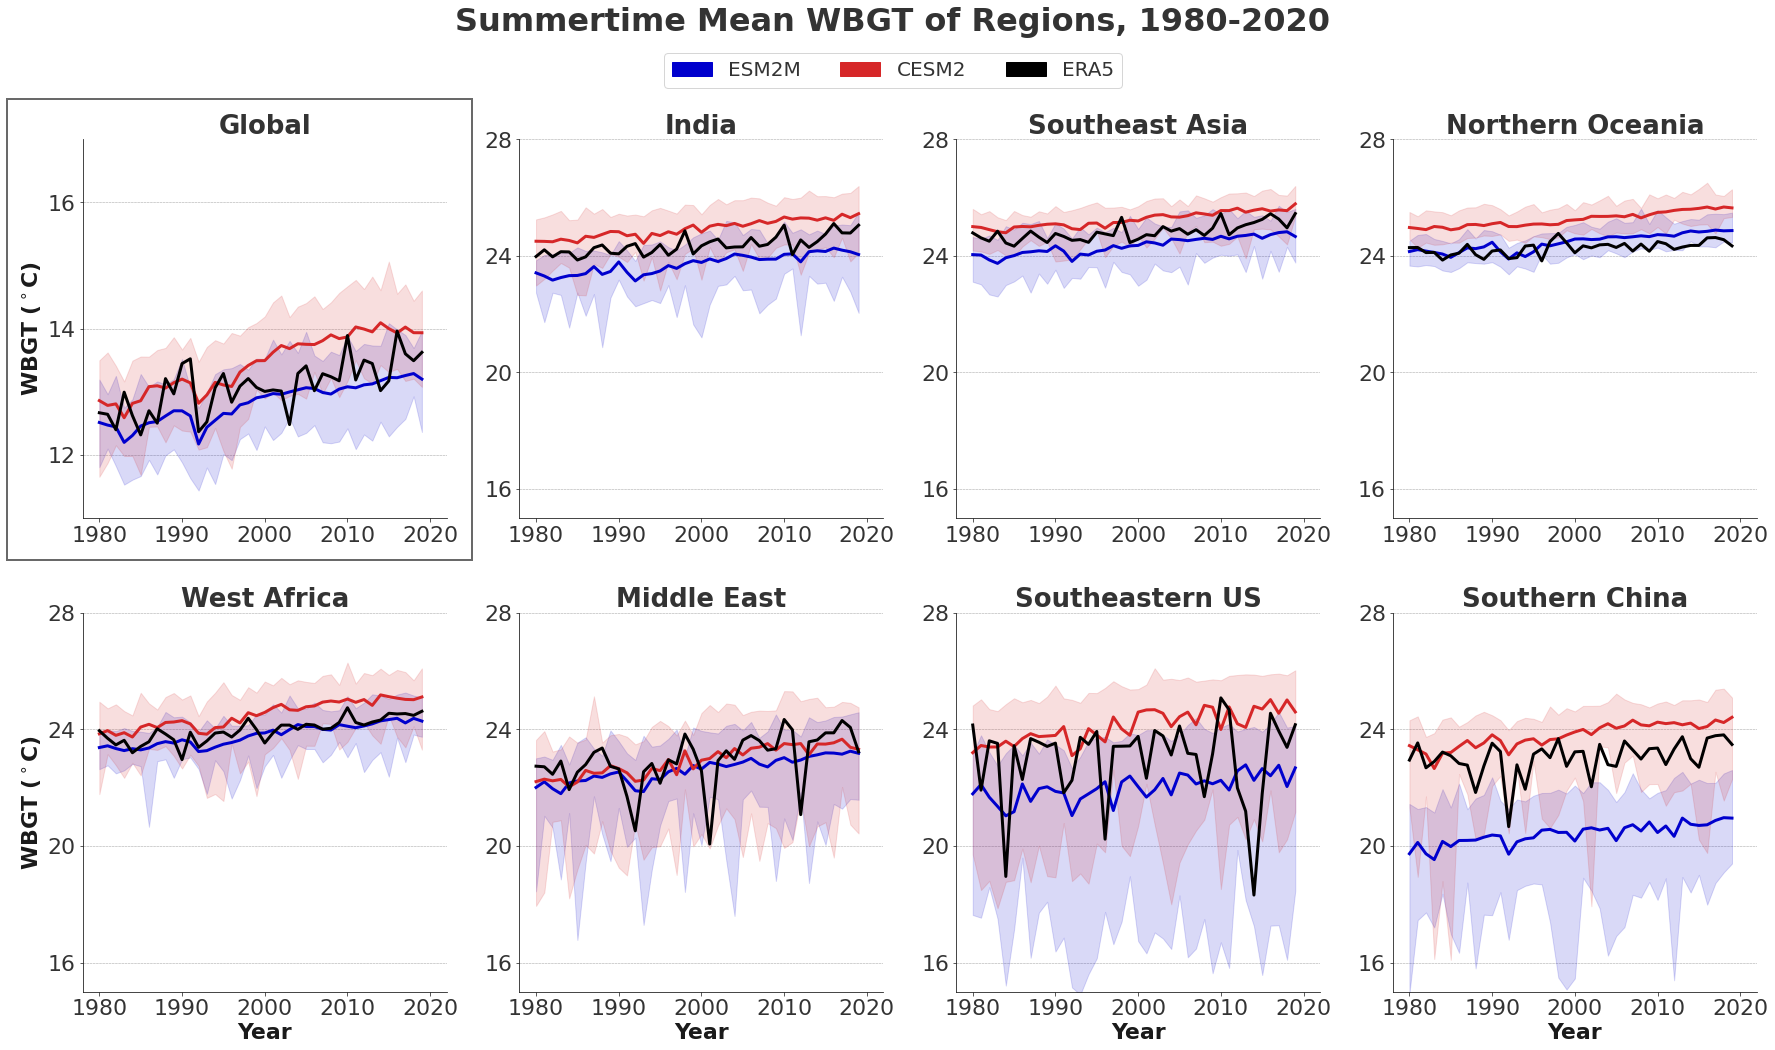

In [138]:
# Regions to plot
regions = ['Global','India','Southeast Asia','Northern Oceania','West Africa','Middle East','Southeastern US','Southern China']

# Create figure and axes
fig, axs = plt.subplots(figsize=(30,16),nrows=2,ncols=4)

# Running counter to determine axis
index = 0

# Loop through regions
for region in regions:
    # Get correct axis
    ax = axs[int(index/4)][index%4]
    
    # Get ToE and population data for region
    wbgt_esm2m = lf.slice_region(ds_esm2m,region,'GFDL')
    area_esm2m = lf.slice_region(land_area_esm2m,region,'GFDL')
    wbgt_cesm2 = lf.slice_region(ds_cesm2,region,'CESM2')
    area_cesm2 = lf.slice_region(land_area_cesm2,region,'CESM2')
    wbgt_era = lf.slice_region(ds_era,region,'CESM2')
    
    # Call function to plot for this region
    xlabel = False
    ylabel = False
    if index>3:
        xlabel = True
    if (index%4)== 0:
        ylabel = True
    plot_panel(wbgt_esm2m,wbgt_cesm2,wbgt_era,area_esm2m,area_cesm2,region,ax,ylabel,xlabel)
    index+=1
    
rect = plt.Rectangle(
    # (lower-left corner), width, height
    (0.09, 0.5), 0.215, 0.4, fill=False, color='dimgray', lw=2, 
    zorder=1000, transform=fig.transFigure, figure=fig
)
fig.patches.extend([rect])

# Set legend
light_blue_patch = mpatches.Patch(color='mediumblue', label='ESM2M')
light_red_patch = mpatches.Patch(color='tab:red', label='CESM2')
black_patch = mpatches.Patch(color='black', label='ERA5')

# Create axis at top for legend
fig.subplots_adjust(top=0.865)
legend_ax = fig.add_axes([0.3, 0.9, 0.4, 0.05])
legend_ax.legend(handles=[light_blue_patch,light_red_patch,black_patch],ncol=3,loc='center');

# Make legend axis markings invisible 
legend_ax.set_frame_on(False)
legend_ax.grid(False)
legend_ax.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)

# Make sure plots don't overlap
fig.subplots_adjust(wspace=.2,hspace=.25)
fig.suptitle('Summertime Mean WBGT of Regions, 1980-2020',fontsize=32,fontweight='bold');

In [130]:
def plot_city(esm2m,cesm2,era,title,ax,ylabel=False,xlabel=False):
    '''Plot a single time series of WBGT 1980-2020'''

    # ESM2M WBGT
    # Plot ensemble envelope (x,y_min,y_max)
    ax.fill_between(esm2m['year'],esm2m.min(dim='ensemble'),esm2m.max(dim='ensemble'),alpha=0.15,color='mediumblue')
    esm2m.mean(dim='ensemble').plot(ax=ax,color='mediumblue',linewidth=3)

    # CESM2 WBGT
    ax.fill_between(cesm2['year'],cesm2.min(dim='ensemble'),cesm2.max(dim='ensemble'),alpha=0.15,color='tab:red')
    cesm2.mean(dim='ensemble').plot(ax=ax,color='tab:red',linewidth=3)

    # ERA WBGT
    era.plot(ax=ax,color='black',linewidth=3)
    
    # Set labels, limits, title
    if xlabel:
        ax.set_xlabel('Year',fontsize=22,fontweight='bold')
    else:
        ax.set_xlabel(None)
    if ylabel:
        ax.set_ylabel('WBGT ($^\circ$C)',fontsize=22,fontweight='bold')
    else:
        ax.set_ylabel(None)

    ax.set_ylim([10,32])
    ax.set_yticks(np.linspace(12,32,6))
    ax.set_xlim([1978,2022])
    ax.set_xticks(np.linspace(1980,2020,5))
    ax.set_title(title,fontsize=26,fontweight='bold')

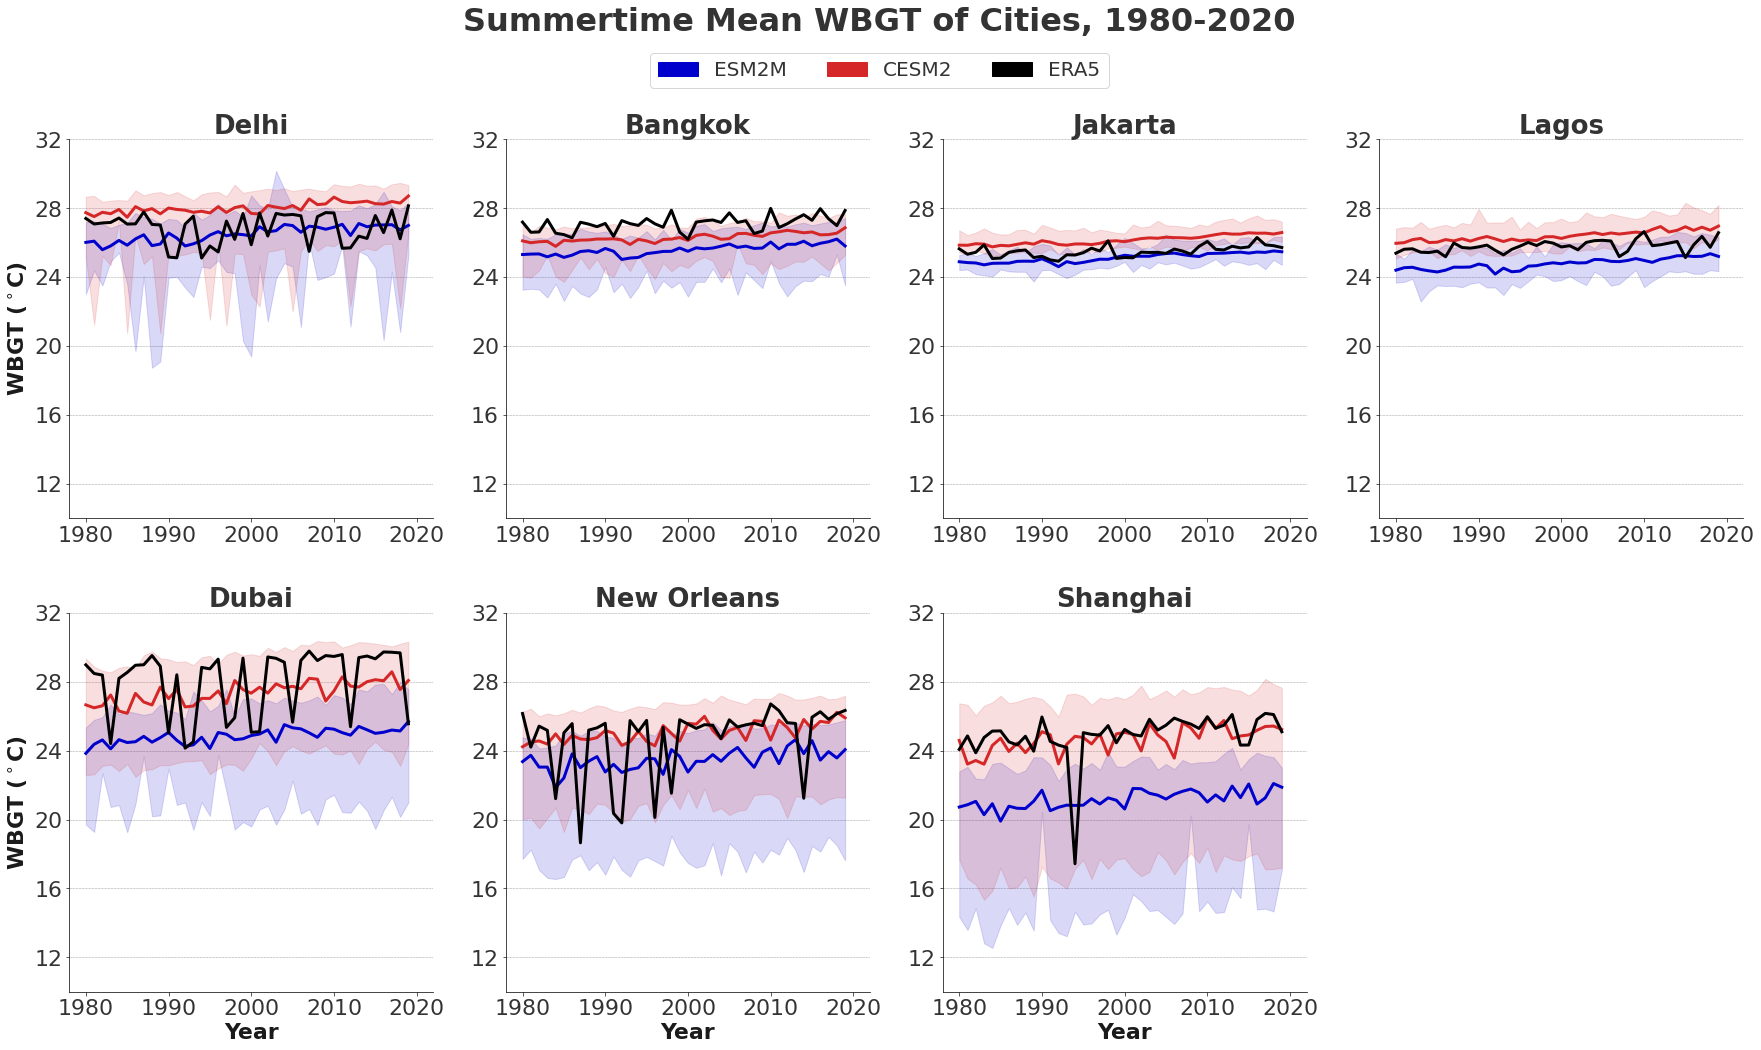

In [137]:
# Cities to plot
regions = ['Delhi','Bangkok','Jakarta','Lagos','Dubai','New Orleans','Shanghai']

# Create figure and axes
fig, axs = plt.subplots(figsize=(30,16),nrows=2,ncols=4)

# Running counter to determine axis
index = 0

# Loop through regions
for region in regions:
    # Get correct axis
    ax = axs[int(index/4)][index%4]
    
    # Get ToE and population data for region
    wbgt_esm2m = lf.slice_city(ds_esm2m,region,'GFDL')
    wbgt_cesm2 = lf.slice_city(ds_cesm2,region,'CESM2')
    wbgt_era = lf.slice_city(ds_era,region,'CESM2')
    
    # Call function to plot for this region
    xlabel = False
    ylabel = False
    if index>3:
        xlabel = True
    if (index%4)== 0:
        ylabel = True
    plot_city(wbgt_esm2m,wbgt_cesm2,wbgt_era,region,ax,ylabel,xlabel)
    index+=1

# Make last axis markings invisible 
axs[1][3].set_frame_on(False)
axs[1][3].grid(False)
axs[1][3].tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)

# Set legend
light_blue_patch = mpatches.Patch(color='mediumblue', label='ESM2M')
light_red_patch = mpatches.Patch(color='tab:red', label='CESM2')
black_patch = mpatches.Patch(color='black', label='ERA5')

# Create axis at top for legend
fig.subplots_adjust(top=0.865)
legend_ax = fig.add_axes([0.3, 0.9, 0.4, 0.05])
legend_ax.legend(handles=[light_blue_patch,light_red_patch,black_patch],ncol=3,loc='center');

# Make legend axis markings invisible 
legend_ax.set_frame_on(False)
legend_ax.grid(False)
legend_ax.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)

# Make sure plots don't overlap
fig.subplots_adjust(wspace=.2,hspace=.25)
fig.suptitle('Summertime Mean WBGT of Cities, 1980-2020',fontsize=32,fontweight='bold');